In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import copy

/home/ogech/CPC/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **MoCov3 model development**

In [2]:
# adapted from https://github.com/facebookresearch/moco-v3.git
class MoCov3(nn.Module):
    def __init__(self,
                 n_chans=4,
                 dim=256,
                 mlp_dim=4096,
                 min_T=0.1,
                 max_T=0.2,
                 dynamic_temp=False,
                 drop_rate=0.0,
                 drop_path_rate=0.0,
                 device='cuda'):
        """
        :param dim: the feature dimension (default: 256)
        :param mlp_dim: the hidden dimension of the MLP (default: 4096)
        :param min_T: the minimum temperature (default: 0.1)
        :param max_T: the maximum temperature (default: 0.2)
        :param dynamic_temp: whether to use dynamic temperature (default: False)
        :param device: the device to use (default: 'cuda')
        """
        super(MoCov3, self).__init__()
        self.min_T = min_T
        self.max_T = max_T
        self.dynamic_temp = dynamic_temp
        self.device = device

        # build encoders
        self.base_encoder = timm.create_model(
            "resnet18",
            in_chans=n_chans,
            num_classes=mlp_dim,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate
        )
        self.momentum_encoder = copy.deepcopy(self.base_encoder)

        # build the projection and prediction heads
        self._build_projection_prediction_heads(dim, mlp_dim)

        for param_m in self.momentum_encoder.parameters():
            param_m.requires_grad = False  # not update by gradient

    def _build_mlp(self, num_layers, input_dim, mlp_dim, output_dim, last_bn=True):
        mlp = []
        for l in range(num_layers):
            dim1 = input_dim if l == 0 else mlp_dim
            dim2 = output_dim if l == num_layers - 1 else mlp_dim

            mlp.append(nn.Linear(dim1, dim2, bias=False))

            if l < num_layers - 1:
                mlp.append(nn.BatchNorm1d(dim2))
                mlp.append(nn.ReLU(inplace=True))
            elif last_bn:
                # follow SimCLR's design: https://github.com/google-research/simclr/blob/master/model_util.py#L157
                # for simplicity, we further removed gamma in BN
                mlp.append(nn.BatchNorm1d(dim2, affine=False))

        return nn.Sequential(*mlp)

    def _build_projection_prediction_heads(self, dim, mlp_dim):
        hidden_dim = self.base_encoder.fc.weight.shape[1]

        del self.base_encoder.fc, self.momentum_encoder.fc  # remove the fc layer # noqa

        # projectors
        self.base_encoder.fc = self._build_mlp(
            2, hidden_dim, mlp_dim, dim)
        self.momentum_encoder.fc = self._build_mlp(
            2, hidden_dim, mlp_dim, dim)

        # predictor
        self.predictor = self._build_mlp(2, dim, mlp_dim, dim, False)

    @torch.no_grad()
    def _update_momentum_encoder(self, m):
        """Momentum update of the momentum encoder"""
        for param_b, param_m in zip(self.base_encoder.parameters(), self.momentum_encoder.parameters()):
            param_m.data = param_m.data * m + param_b.data * (1. - m)

    def _get_temp(self, cosine_sim: torch.Tensor):
        """
        Get the temperature for the contrastive loss based on this paper 
        https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10820841
        """
        return self.min_T + 0.5*(self.max_T - self.min_T)*(1+torch.cos((1 + cosine_sim)*torch.tensor(torch.pi)))

    def contrastive_loss(self, q, k):
        # normalize
        q = nn.functional.normalize(q, dim=1)
        k = nn.functional.normalize(k, dim=1)
        logits = torch.einsum('nc,mc->nm', [q, k])
        logits /= self._get_temp(logits.detach()
                                 ) if self.dynamic_temp else self.min_T
        labels = torch.arange(
            logits.shape[0], dtype=torch.long).to(self.device)

        return nn.CrossEntropyLoss()(logits, labels) * 2 * self.min_T \
            if self.dynamic_temp else nn.CrossEntropyLoss()(logits, labels), logits

    def forward(self, x1, x2, m):
        """
        :param x1: the first input
        :type x1: torch.Tensor
        :param x2: the second input
        :type x2: torch.Tensor
        :param m: the momentum coefficient
        :type m: float
        """

        # compute features
        q1 = self.predictor(self.base_encoder(x1))
        q2 = self.predictor(self.base_encoder(x2))

        with torch.no_grad():  # no gradient
            self._update_momentum_encoder(m)  # update the momentum encoder

            # compute momentum features as targets
            k1 = self.momentum_encoder(x1)
            k2 = self.momentum_encoder(x2)

        l1, sim1 = self.contrastive_loss(q1, k2)
        l2, sim2 = self.contrastive_loss(q2, k1)
        return l1 + l2, sim1, sim2

### **Training**

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda
import h5py
import numpy as np
from tqdm.autonotebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
import yaml

In [4]:
config = {
    "n_chans": 4,
    "dim": 256,
    "mlp_dim": 1024,
    "drop_rate": 0.0,
    "drop_path_rate": 0.0,
    "temperature": 0.2,
    "dynamic_temp": True,
    "batch_size": 1024,
    "experiment_name": f"mocov3_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    "num_epochs": 100,
    "moco_m": 0.996,
    "knn_k": 200,
    "knn_t": 0.1,
    "learning_rate": 0.03,
    "weight_decay": 1e-4,
    "dataset_path": "./datasets",
    "checkpoint_path": None,
    "comment": "MoCov3 model training",
}

In [5]:
class R22_Dataset(Dataset):
    """
    Avoid loading the entire dataset into memory.
    """

    def __init__(self, h5_path,
                 input_label="iq_data",
                 target_label="angles",
                 txfms=None):
        self.h5_path = h5_path
        self.input_label = input_label
        self.target_label = target_label
        self.txfms = txfms
        self._file = None

    def _ensure_open(self):
        if self._file is None:
            # open in read-only, latest libver, SWMR if you know no writers
            self._file = h5py.File(
                self.h5_path, 'r', libver='latest', swmr=True)
            self._x = self._file[self.input_label]
            self._y = self._file[self.target_label]

    def __len__(self):
        self._ensure_open()
        return self._x.shape[0]

    def __getitem__(self, idx):
        self._ensure_open()
        x = self._x[idx]
        y = self._y[idx]
        if self.txfms:
            x = self.txfms(x)
        return x, y

    def __del__(self):
        if self._file is not None:
            self._file.close()

In [6]:
class RandomZeroMasking:
    """
    https://arxiv.org/pdf/2207.03046
    :param max_rate: Maximum rate of zero masking.
    :type max_rate: float (default = 0.1)
    :param dim: Dimension to apply zero masking.
    :type dim: int (default = -1)
    :rtype: torch.Tensor
    """

    def __init__(self, max_rate=.1, dim=-1):
        self.max_rate = max_rate
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        mask_size = torch.randint(
            0, int(x.size(self.dim)*self.max_rate) + 1, (1,)).item()
        mask = torch.ones_like(x).to(x.device)
        mask_idx = [slice(None)] * x.ndim
        rand_start_idxs = torch.randint(
            0, x.size(self.dim), (max(min((x.size(self.dim) - mask_size) // 5, 5), 1),))
        mask_idx[self.dim] = torch.flatten(rand_start_idxs.unsqueeze(1)
                                           + torch.arange(mask_size).unsqueeze(0))
        mask_idx[self.dim] = mask_idx[self.dim].clamp(0, x.size(self.dim) - 1)
        mask[mask_idx] = 0
        return x * mask


class RandomAntennaDropout:
    """
    https://arxiv.org/pdf/2312.04519
    :param rate: Dropout rate.
    :type rate: float (default = 0.1)
    :param arrangement: Channel arrangement. 'interleaved' or 'grouped'
    :type arrangement: str (default = 'grouped')
    :rtype: torch.Tensor
    """

    def __init__(self, rate=0.1, arrangement='grouped'):
        self.rate = rate
        self.arrangement = arrangement

    def __call__(self, x: torch.Tensor):
        x = x.clone()  # avoid modifying the input tensor
        if x.ndim == 3:
            # Handling x of shape [4, 2, 4096]
            mask = (torch.rand(*x.shape[:-2], 1, 1) > self.rate).float()
            # Apply mask independently to each [2, 4096] pair
            x = x * mask.to(x.device)
            return x

        num_pairs = x.size(-2) // 2

        if self.arrangement == 'interleaved':
            mask = (torch.rand(*x.shape[:-2], num_pairs, 1) >
                    self.rate).repeat_interleave(2, dim=1)
            x = x * mask.to(x.device)

        elif self.arrangement == 'grouped':
            mask = (torch.rand(*x.shape[:-2],
                    num_pairs, 1) > self.rate).float()
            x[:num_pairs, :] *= mask.to(x.device)
            x[num_pairs:, :] *= mask

        return x


class RandomCircularShift:
    """
    :param max_shift: Maximum shift as a fraction of the sequence length (1.0 means full length).
    :type max_shift: float (default is 1.0)
    """

    def __init__(self, max_shift=1.0):
        self.max_shift = max_shift

    def __call__(self, x: torch.Tensor):
        T = x.size(-1)
        m = int(T * self.max_shift)
        shift = torch.randint(-m, m + 1, (1,)).item()
        return torch.roll(x, shifts=shift, dims=-1)


class Jitter:
    """
    https://arxiv.org/pdf/2007.15951
    :param var: Variance of the Gaussian noise.
    :type var: float (default = 1e-5)
    """

    def __init__(self, var=1e-5):
        self.var = var

    def __call__(self, x: torch.Tensor):
        noise = torch.randn_like(x).to(x.device) * self.var
        return x + noise

In [7]:
class MoCoTransform:
    """Take two random transform of one data"""

    def __init__(self, base_transform1, base_transform2):
        self.base_transform1 = base_transform1
        self.base_transform2 = base_transform2

    def __call__(self, x):
        x1 = self.base_transform1(x)
        x2 = self.base_transform2(x)
        return [x1, x2]

In [8]:
aug1 = Compose([
    Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    RandomZeroMasking(max_rate=0.2),
    RandomAntennaDropout(rate=0.1),
    RandomCircularShift(max_shift=0.3),
    Jitter(var=1e-5),
])

aug2 = Compose([
    Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    RandomZeroMasking(max_rate=0.2),
    RandomAntennaDropout(rate=0.1),
    RandomCircularShift(max_shift=0.3),
    Jitter(var=1e-5),
])

train_ds = R22_Dataset(
    os.path.join(config["dataset_path"], "train_preprocessed.h5"),
    input_label="iq_data",
    target_label="angles",
    txfms=MoCoTransform(aug1, aug2)
)

memory_ds = R22_Dataset(
    os.path.join(config["dataset_path"], "train_preprocessed.h5"),
    input_label="iq_data",
    target_label="angles"
)

test_ds = R22_Dataset(
    os.path.join(config["dataset_path"], "test_preprocessed.h5"),
    input_label="iq_data",
    target_label="angles"
)

# test with a small dataset
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
idx = torch.randperm(len(train_ds))[:225*1000]
train_ds = torch.utils.data.Subset(train_ds, idx)
idx = torch.randperm(len(memory_ds))[:225*1000]
memory_ds = torch.utils.data.Subset(memory_ds, idx)
idx = torch.randperm(len(test_ds))[:225*10]
test_ds = torch.utils.data.Subset(test_ds, idx)

prefetch_factor = 2
num_workers = 8
persistent_workers = True
pin_memory = True

train_loader = DataLoader(
    train_ds,
    batch_size=config["batch_size"],
    shuffle=True,
    prefetch_factor=prefetch_factor,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
    pin_memory=pin_memory,
    drop_last=True
)

memory_loader = DataLoader(
    memory_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    prefetch_factor=prefetch_factor,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
    pin_memory=pin_memory,
    drop_last=False
)
test_loader = DataLoader(
    test_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    prefetch_factor=prefetch_factor,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
    pin_memory=pin_memory,
    drop_last=False
)

(xb1, xb2), yb = next(iter(train_loader))
print(xb1.shape, xb2.shape, yb.shape)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

torch.Size([1024, 4, 2, 1024]) torch.Size([1024, 4, 2, 1024]) torch.Size([1024])


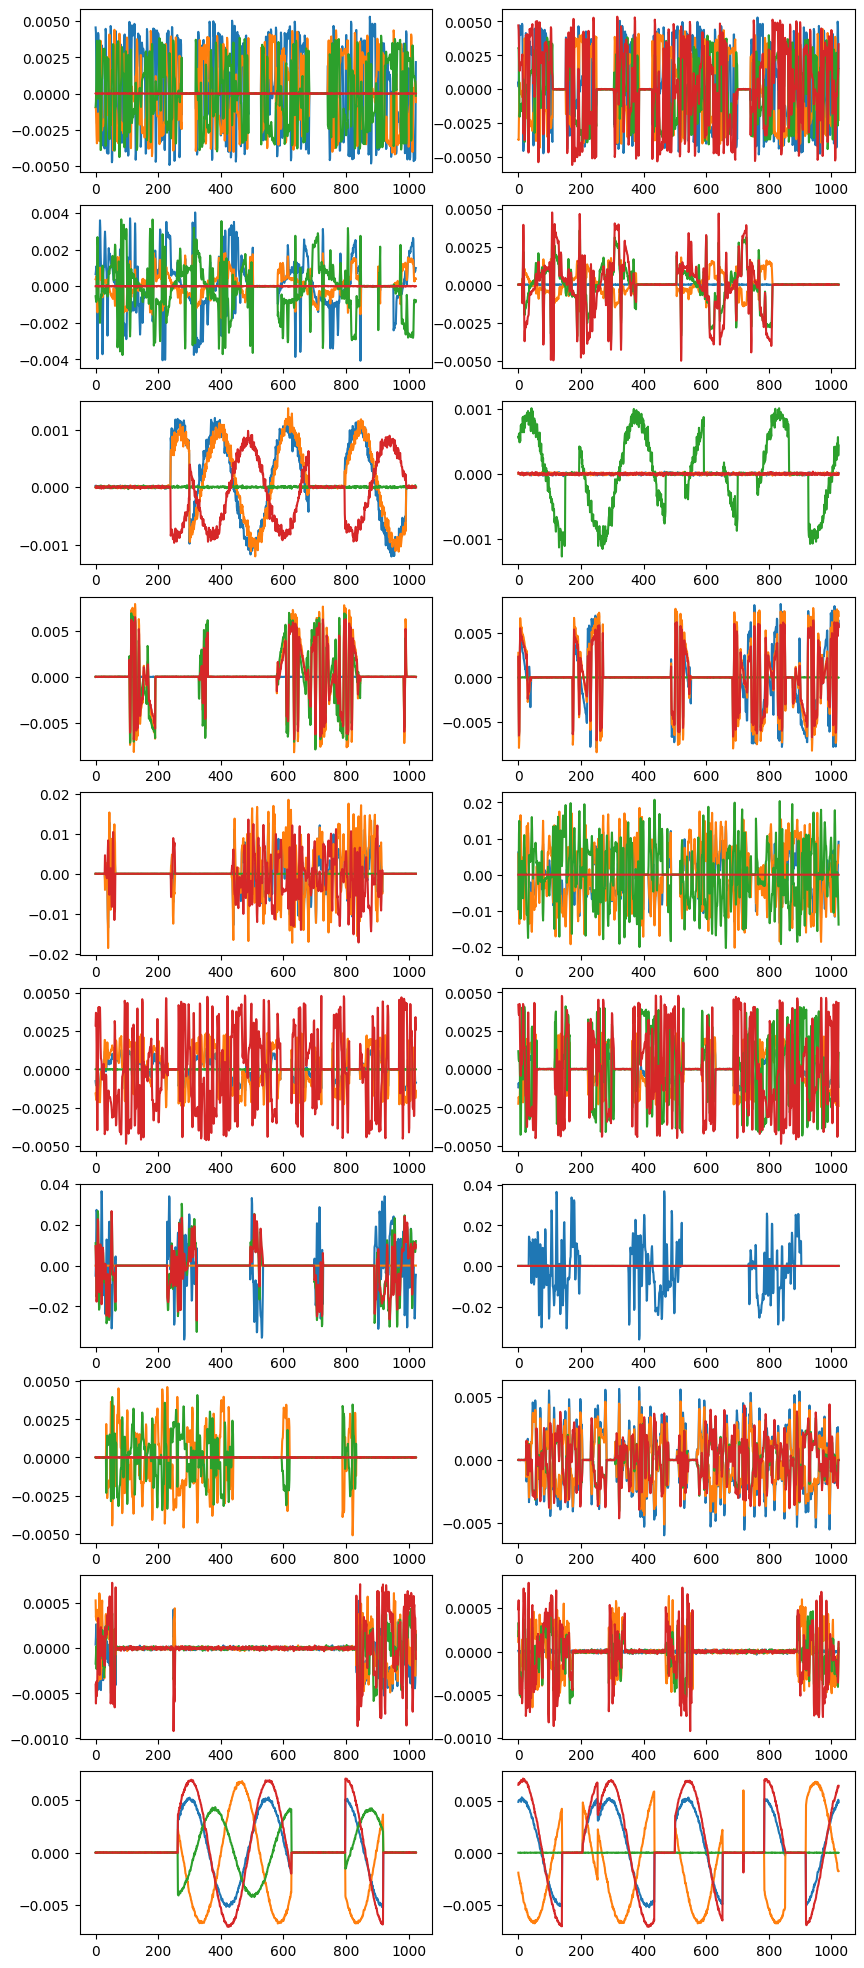

In [9]:
# double checking dataloading pipeline and augmentation
import matplotlib.pyplot as plt

_, axs = plt.subplots(10, 2, figsize=(10, 25))
idxs = torch.randint(0, config["batch_size"], (10,))
for i, idx in enumerate(idxs):
    # each example is a 4 by 2 by k tensor
    axs[i, 0].plot(xb1[idx, :, 0].cpu().numpy().T)
    axs[i, 1].plot(xb2[idx, :, 0].cpu().numpy().T)

In [10]:
# test the model
model = MoCov3(
    n_chans=config["n_chans"],
    dim=config["dim"],
    mlp_dim=config["mlp_dim"],
    drop_rate=config["drop_rate"],
    drop_path_rate=config["drop_path_rate"],
    min_T=config["temperature"],
    dynamic_temp=config["dynamic_temp"],
    device=device
).to(device)

print(
    f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

loss, *_ = model(xb1.to(device), xb2.to(device), 0.999)
print(loss)

Model has 12,494,464 trainable parameters


tensor(5.5200, device='cuda:1', grad_fn=<AddBackward0>)


In [11]:
class Tracker:
    """
    A class to track the best value of a metric.

    :param metric: The name of the metric to track. If 'loss' is in the metric name, the goal is to minimize it.
    :type metric: str
    :param mode: The mode of tracking. Can be 'auto', 'min', or 'max'. Default is 'auto'.
    :type mode: str, optional
    """

    def __init__(self, metric, mode='auto'):
        self.metric = metric
        self.mode = mode
        self.mode_dict = {
            'auto': np.less if 'loss' in metric else np.greater,
            'min': np.less,
            'max': np.greater
        }
        self.operator = self.mode_dict[mode]
        self._best = np.inf if self.operator == np.less else -np.inf

    @property
    def best(self):
        return self._best

    @best.setter
    def best(self, value):
        self._best = value

In [12]:
def knn_predict(feature, feature_bank, feature_labels, num_classes, k=200, t=0.1):
    # feature is [b, d], feature_bank is [d, n] and feature_labels is [n]
    sim_mat = torch.mm(feature, feature_bank)  # [b, n]
    sim_weight, sim_indices = sim_mat.topk(k, dim=-1)  # [b, k]
    sim_labels = torch.gather(feature_labels.expand(
        feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / t).exp()

    # count for each class
    one_hot = torch.zeros(feature.size(0) * k, num_classes).to(feature.device)
    one_hot = one_hot.scatter(
        dim=-1, index=sim_labels.view(-1, 1), value=1.0)  # [b*k, num_classes]
    pred_scores = torch.sum(one_hot.view(feature.size(0), -1, num_classes) * sim_weight.unsqueeze(dim=-1), dim=1)  # weighted scores [b, num_classes] # noqa

    pred_labels = pred_scores.argsort(
        dim=-1, descending=True)  # [b, num_classes]
    return pred_labels


@torch.no_grad()
def knn_evaluate(model, memory_loader, test_loader, epoch, config, pbar, writer, device):
    feature_bank, feature_labels = [], []
    encoder = copy.deepcopy(model.base_encoder)
    encoder.fc = nn.Identity()
    encoder = encoder.to(device)
    encoder.eval()
    for x, y in tqdm(memory_loader, desc="Extracting features", leave=False):
        x, y = x.to(device), y.to(device)
        feature = encoder(x)
        # normalize the feature
        feature = F.normalize(feature, dim=-1)
        feature_bank.append(feature)
        feature_labels.append(y)
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()  # [d, n]
    feature_labels = torch.cat(feature_labels, dim=0)  # [n]

    # loop over the test set
    total_num, top1, top5 = 0, 0, 0
    for x, y in tqdm(test_loader, desc="Testing", leave=False):
        x, y = x.to(device), y.to(device)
        feature = encoder(x)
        # normalize the feature
        feature = F.normalize(feature, dim=-1)
        pred_labels = knn_predict(feature, feature_bank, feature_labels,
                                  num_classes=config["nclasses"], k=config["knn_k"], t=config["knn_t"])
        top1 += (pred_labels[:, 0] == y).sum().item()
        top5 += (pred_labels[:, :5] == y.unsqueeze(1)).sum().item()
        total_num += y.size(0)
    pbar.write(
        f"Epoch [{epoch}/{config['num_epochs']}] Acc@1: {top1 / total_num * 100:.2f}%, Acc@5: {top5 / total_num * 100:.2f}%"
    )
    writer.add_scalar(
        f"test/top1", top1 / total_num * 100, epoch)
    writer.add_scalar(
        f"test/top5", top5 / total_num * 100, epoch)

In [13]:
def adjust_moco_momentum(epoch, config):
    return 1. - 0.5 * (1 + np.cos(np.pi * epoch /
                                  config["num_epochs"])) * (1 - config["moco_m"])

In [14]:
class LARS(torch.optim.Optimizer):
    """
    LARS optimizer, no rate scaling or weight decay for parameters <= 1D.
    """

    def __init__(self, params, lr=0, weight_decay=0, momentum=0.9, trust_coefficient=0.001):
        defaults = dict(lr=lr, weight_decay=weight_decay,
                        momentum=momentum, trust_coefficient=trust_coefficient)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if p.ndim > 1:  # if not normalization gamma/beta or bias
                    dp = dp.add(p, alpha=g['weight_decay'])
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                                (g['trust_coefficient'] * param_norm / update_norm), one),
                                    one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)
                p.add_(mu, alpha=-g['lr'])

In [ ]:
# add the label encoder angles to the config
with open("label_encoder_angles.yaml", "r") as f:
    label_encoder_angles = yaml.safe_load(f)
config.update(**label_encoder_angles)
# dump the config
path = os.path.join("./experiments", config["experiment_name"])
os.makedirs(path, exist_ok=True)
with open(os.path.join(path, "config.yaml"), "w") as f:
    yaml.dump(config, f, default_flow_style=False)

optim = LARS(
    model.parameters(),
    lr=config["learning_rate"] * config["batch_size"] / 256,
    weight_decay=config["weight_decay"],
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    T_max=config["num_epochs"],
    eta_min=1e-6,
)

scaler = torch.amp.GradScaler(device=device.type, enabled=True)
writer = SummaryWriter(
    log_dir=os.path.join("./experiments/", config["experiment_name"]),
)
tracker = Tracker("loss/epoch", mode="min")

start_epoch = 0
# resume training from a checkpoint if it exists
checkpoint_path = config["checkpoint_path"]
if checkpoint_path and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    optim.load_state_dict(checkpoint["opt_state_dict"])
    scheduler.load_state_dict(checkpoint["sch_state_dict"])
    start_epoch = checkpoint["epoch"]
    print(f"Resuming training from epoch {start_epoch}")

step = 0
with tqdm(range(start_epoch, config["num_epochs"])) as master_bar:
    for epoch in master_bar:
        model.train()
        avg_loss = 0.0
        moco_m = config["moco_m"]  # reset every epoch
        with tqdm(train_loader, leave=False) as pbar:
            for (xb1, xb2), _ in pbar:
                xb1, xb2 = xb1.to(device), xb2.to(device)
                optim.zero_grad()

                moco_m = adjust_moco_momentum(epoch, config)
                with torch.amp.autocast(device_type=device.type,
                                        enabled=True):
                    loss, *_ = model(xb1, xb2, moco_m)

                scaler.scale(loss).backward()
                # # clip gradients
                # scaler.unscale_(optim)
                # norm = torch.nn.utils.clip_grad_norm_(
                #     model.parameters(), 1.0, norm_type=2
                # )
                scaler.step(optim)
                scaler.update()

                avg_loss += loss.item()

                pbar.set_postfix(
                    {"loss/step": loss.item(),
                     #  "norm": norm.item()
                     })
                writer.add_scalar("loss/step", loss.item(), step)
                # writer.add_scalar("norm/step", norm.item(), step)
                step += 1
                pbar.update(1)

        avg_loss /= len(train_loader)
        writer.add_scalar("loss/epoch", avg_loss, epoch)
        master_bar.write(f"Epoch {epoch}: loss = {avg_loss:.4f}")
        scheduler.step()
        writer.add_scalar(
            "learning_rate/epoch",
            optim.param_groups[0]["lr"],
            epoch,
        )

        # evaluate the model
        knn_evaluate(
            model,
            memory_loader,
            test_loader,
            epoch,
            config,
            master_bar,
            writer,
            device,
        )

        writer.flush()
        if tracker.operator(avg_loss, tracker.best):
            tracker.best = avg_loss
            # Save the model checkpoint
            checkpoint_path = os.path.join(
                "./experiments", f"{config['experiment_name']}/weights.pth"
            )
            torch.save(model.state_dict(), checkpoint_path)
            master_bar.write(f"Model saved to {checkpoint_path}")
        # save the latest checkpoint
        checkpoint_path = os.path.join(
            "./experiments", f"{config['experiment_name']}/last_checkpoint.pt")
        torch.save({
            "state_dict": model.state_dict(),
            "opt_state_dict": optim.state_dict(),
            "sch_state_dict": scheduler.state_dict(),
            "epoch": epoch}, checkpoint_path)
        master_bar.write(
            f"Latest checkpoint saved to {checkpoint_path} at epoch {epoch}"
        )

writer.close()
print("Training complete.")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [02:10<?, ?it/s]

Epoch 0: loss = 4.2668


  0%|          | 0/100 [03:48<?, ?it/s]

Epoch [0/100] Acc@1: 9.20%, Acc@5: 42.58%
Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  1%|          | 1/100 [03:48<6:17:05, 228.54s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 0


  1%|          | 1/100 [06:02<6:17:05, 228.54s/it]

Epoch 1: loss = 3.7912


  1%|          | 1/100 [07:38<6:17:05, 228.54s/it]

Epoch [1/100] Acc@1: 9.82%, Acc@5: 44.62%


  1%|          | 1/100 [07:39<6:17:05, 228.54s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  2%|▏         | 2/100 [07:39<6:15:50, 230.11s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 1


  2%|▏         | 2/100 [09:53<6:15:50, 230.11s/it]

Epoch 2: loss = 3.5699


  2%|▏         | 2/100 [11:30<6:15:50, 230.11s/it]

Epoch [2/100] Acc@1: 10.27%, Acc@5: 48.09%


  2%|▏         | 2/100 [11:30<6:15:50, 230.11s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  3%|▎         | 3/100 [11:30<6:12:46, 230.58s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 2


  3%|▎         | 3/100 [13:44<6:12:46, 230.58s/it]

Epoch 3: loss = 3.4443


  3%|▎         | 3/100 [15:21<6:12:46, 230.58s/it]

Epoch [3/100] Acc@1: 10.84%, Acc@5: 48.67%


  3%|▎         | 3/100 [15:21<6:12:46, 230.58s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  4%|▍         | 4/100 [15:22<6:09:23, 230.87s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 3


  4%|▍         | 4/100 [17:35<6:09:23, 230.87s/it]

Epoch 4: loss = 3.3504


  4%|▍         | 4/100 [19:12<6:09:23, 230.87s/it]

Epoch [4/100] Acc@1: 11.96%, Acc@5: 51.11%


  4%|▍         | 4/100 [19:12<6:09:23, 230.87s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  5%|▌         | 5/100 [19:13<6:05:43, 230.99s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 4


  5%|▌         | 5/100 [21:26<6:05:43, 230.99s/it]

Epoch 5: loss = 3.2742


  5%|▌         | 5/100 [23:03<6:05:43, 230.99s/it]

Epoch [5/100] Acc@1: 11.33%, Acc@5: 49.91%


  5%|▌         | 5/100 [23:04<6:05:43, 230.99s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  6%|▌         | 6/100 [23:04<6:02:01, 231.08s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 5


  6%|▌         | 6/100 [25:18<6:02:01, 231.08s/it]

Epoch 6: loss = 3.2152


  6%|▌         | 6/100 [26:54<6:02:01, 231.08s/it]

Epoch [6/100] Acc@1: 11.38%, Acc@5: 50.98%


  6%|▌         | 6/100 [26:55<6:02:01, 231.08s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  7%|▋         | 7/100 [26:55<5:58:06, 231.04s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 6


  7%|▋         | 7/100 [29:09<5:58:06, 231.04s/it]

Epoch 7: loss = 3.1634


  7%|▋         | 7/100 [30:45<5:58:06, 231.04s/it]

Epoch [7/100] Acc@1: 12.00%, Acc@5: 51.02%


  7%|▋         | 7/100 [30:46<5:58:06, 231.04s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  8%|▊         | 8/100 [30:47<5:54:32, 231.23s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 7


  8%|▊         | 8/100 [33:00<5:54:32, 231.23s/it]

Epoch 8: loss = 3.1201


  8%|▊         | 8/100 [35:47<5:54:32, 231.23s/it]

Epoch [8/100] Acc@1: 13.24%, Acc@5: 53.02%


  8%|▊         | 8/100 [35:47<5:54:32, 231.23s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


  9%|▉         | 9/100 [35:49<6:24:09, 253.29s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 8


  9%|▉         | 9/100 [38:02<6:24:09, 253.29s/it]

Epoch 9: loss = 3.0835


  9%|▉         | 9/100 [40:55<6:24:09, 253.29s/it]

Epoch [9/100] Acc@1: 13.73%, Acc@5: 53.07%


  9%|▉         | 9/100 [40:55<6:24:09, 253.29s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 10%|█         | 10/100 [40:56<6:45:07, 270.08s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 9


 10%|█         | 10/100 [43:10<6:45:07, 270.08s/it]

Epoch 10: loss = 3.0489


 10%|█         | 10/100 [46:04<6:45:07, 270.08s/it]

Epoch [10/100] Acc@1: 12.71%, Acc@5: 52.36%


 10%|█         | 10/100 [46:04<6:45:07, 270.08s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 11%|█         | 11/100 [46:05<6:58:24, 282.07s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 10


 11%|█         | 11/100 [48:19<6:58:24, 282.07s/it]

Epoch 11: loss = 3.0185


 11%|█         | 11/100 [51:24<6:58:24, 282.07s/it]

Epoch [11/100] Acc@1: 14.31%, Acc@5: 54.22%


 11%|█         | 11/100 [51:25<6:58:24, 282.07s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 12%|█▏        | 12/100 [51:26<7:10:42, 293.67s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 11


 12%|█▏        | 12/100 [53:40<7:10:42, 293.67s/it]

Epoch 12: loss = 2.9936


 12%|█▏        | 12/100 [56:50<7:10:42, 293.67s/it]

Epoch [12/100] Acc@1: 14.00%, Acc@5: 54.13%


 12%|█▏        | 12/100 [56:51<7:10:42, 293.67s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 13%|█▎        | 13/100 [56:52<7:20:04, 303.50s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 12


 13%|█▎        | 13/100 [59:06<7:20:04, 303.50s/it]

Epoch 13: loss = 2.9708


 13%|█▎        | 13/100 [1:01:55<7:20:04, 303.50s/it]

Epoch [13/100] Acc@1: 13.96%, Acc@5: 53.64%


 13%|█▎        | 13/100 [1:01:55<7:20:04, 303.50s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 14%|█▍        | 14/100 [1:01:56<7:15:28, 303.82s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 13


 14%|█▍        | 14/100 [1:04:10<7:15:28, 303.82s/it]

Epoch 14: loss = 2.9492


 14%|█▍        | 14/100 [1:07:13<7:15:28, 303.82s/it]

Epoch [14/100] Acc@1: 14.04%, Acc@5: 53.69%


 14%|█▍        | 14/100 [1:07:14<7:15:28, 303.82s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 15%|█▌        | 15/100 [1:07:14<7:16:31, 308.13s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 14


 15%|█▌        | 15/100 [1:09:28<7:16:31, 308.13s/it]

Epoch 15: loss = 2.9295


 15%|█▌        | 15/100 [1:12:25<7:16:31, 308.13s/it]

Epoch [15/100] Acc@1: 14.62%, Acc@5: 54.36%


 15%|█▌        | 15/100 [1:12:26<7:16:31, 308.13s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 16%|█▌        | 16/100 [1:12:27<7:13:05, 309.35s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 15


 16%|█▌        | 16/100 [1:14:40<7:13:05, 309.35s/it]

Epoch 16: loss = 2.9143


 16%|█▌        | 16/100 [1:17:40<7:13:05, 309.35s/it]

Epoch [16/100] Acc@1: 14.49%, Acc@5: 54.80%


 16%|█▌        | 16/100 [1:17:41<7:13:05, 309.35s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 17%|█▋        | 17/100 [1:17:41<7:10:12, 310.99s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 16


 17%|█▋        | 17/100 [1:19:55<7:10:12, 310.99s/it]

Epoch 17: loss = 2.8966


 17%|█▋        | 17/100 [1:23:03<7:10:12, 310.99s/it]

Epoch [17/100] Acc@1: 14.71%, Acc@5: 55.73%


 17%|█▋        | 17/100 [1:23:03<7:10:12, 310.99s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 18%|█▊        | 18/100 [1:23:04<7:09:56, 314.60s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 17


 18%|█▊        | 18/100 [1:25:18<7:09:56, 314.60s/it]

Epoch 18: loss = 2.8823


 18%|█▊        | 18/100 [1:28:14<7:09:56, 314.60s/it]

Epoch [18/100] Acc@1: 15.60%, Acc@5: 54.80%


 18%|█▊        | 18/100 [1:28:15<7:09:56, 314.60s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 19%|█▉        | 19/100 [1:28:16<7:03:26, 313.66s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 18


 19%|█▉        | 19/100 [1:30:30<7:03:26, 313.66s/it]

Epoch 19: loss = 2.8700


 19%|█▉        | 19/100 [1:33:37<7:03:26, 313.66s/it]

Epoch [19/100] Acc@1: 15.78%, Acc@5: 54.84%


 19%|█▉        | 19/100 [1:33:38<7:03:26, 313.66s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 20%|██        | 20/100 [1:33:39<7:01:54, 316.43s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 19


 20%|██        | 20/100 [1:35:53<7:01:54, 316.43s/it]

Epoch 20: loss = 2.8557


 20%|██        | 20/100 [1:39:04<7:01:54, 316.43s/it]

Epoch [20/100] Acc@1: 15.91%, Acc@5: 55.60%


 20%|██        | 20/100 [1:39:04<7:01:54, 316.43s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 21%|██        | 21/100 [1:39:05<7:00:20, 319.24s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 20


 21%|██        | 21/100 [1:41:18<7:00:20, 319.24s/it]

Epoch 21: loss = 2.8446


 21%|██        | 21/100 [1:44:54<7:00:20, 319.24s/it]

Epoch [21/100] Acc@1: 14.49%, Acc@5: 56.13%


 21%|██        | 21/100 [1:44:55<7:00:20, 319.24s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 22%|██▏       | 22/100 [1:44:56<7:07:25, 328.79s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 21


 22%|██▏       | 22/100 [1:47:10<7:07:25, 328.79s/it]

Epoch 22: loss = 2.8328


 22%|██▏       | 22/100 [1:50:22<7:07:25, 328.79s/it]

Epoch [22/100] Acc@1: 16.13%, Acc@5: 55.69%


 22%|██▏       | 22/100 [1:50:23<7:07:25, 328.79s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 23%|██▎       | 23/100 [1:50:23<7:01:30, 328.45s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 22


 23%|██▎       | 23/100 [1:52:37<7:01:30, 328.45s/it]

Epoch 23: loss = 2.8213


 23%|██▎       | 23/100 [1:55:41<7:01:30, 328.45s/it]

Epoch [23/100] Acc@1: 16.00%, Acc@5: 56.36%


 23%|██▎       | 23/100 [1:55:42<7:01:30, 328.45s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 24%|██▍       | 24/100 [1:55:43<6:52:38, 325.77s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 23


 24%|██▍       | 24/100 [1:57:57<6:52:38, 325.77s/it]

Epoch 24: loss = 2.8124


 24%|██▍       | 24/100 [2:01:06<6:52:38, 325.77s/it]

Epoch [24/100] Acc@1: 16.36%, Acc@5: 56.36%


 24%|██▍       | 24/100 [2:01:07<6:52:38, 325.77s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 25%|██▌       | 25/100 [2:01:08<6:46:55, 325.54s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 24


 25%|██▌       | 25/100 [2:03:22<6:46:55, 325.54s/it]

Epoch 25: loss = 2.8021


 25%|██▌       | 25/100 [2:06:21<6:46:55, 325.54s/it]

Epoch [25/100] Acc@1: 14.89%, Acc@5: 55.64%


 25%|██▌       | 25/100 [2:06:21<6:46:55, 325.54s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 26%|██▌       | 26/100 [2:06:22<6:37:23, 322.21s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 25


 26%|██▌       | 26/100 [2:08:37<6:37:23, 322.21s/it]

Epoch 26: loss = 2.7924


 26%|██▌       | 26/100 [2:11:36<6:37:23, 322.21s/it]

Epoch [26/100] Acc@1: 16.27%, Acc@5: 56.58%


 26%|██▌       | 26/100 [2:11:37<6:37:23, 322.21s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 27%|██▋       | 27/100 [2:11:38<6:29:43, 320.32s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 26


 27%|██▋       | 27/100 [2:13:52<6:29:43, 320.32s/it]

Epoch 27: loss = 2.7841


 27%|██▋       | 27/100 [2:17:04<6:29:43, 320.32s/it]

Epoch [27/100] Acc@1: 16.67%, Acc@5: 55.78%


 27%|██▋       | 27/100 [2:17:05<6:29:43, 320.32s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 28%|██▊       | 28/100 [2:17:06<6:27:00, 322.51s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 27


 28%|██▊       | 28/100 [2:19:20<6:27:00, 322.51s/it]

Epoch 28: loss = 2.7777


 28%|██▊       | 28/100 [2:22:44<6:27:00, 322.51s/it]

Epoch [28/100] Acc@1: 16.89%, Acc@5: 56.58%


 28%|██▊       | 28/100 [2:22:45<6:27:00, 322.51s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 29%|██▉       | 29/100 [2:22:46<6:27:56, 327.84s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 28


 29%|██▉       | 29/100 [2:25:01<6:27:56, 327.84s/it]

Epoch 29: loss = 2.7691


 29%|██▉       | 29/100 [2:28:14<6:27:56, 327.84s/it]

Epoch [29/100] Acc@1: 16.09%, Acc@5: 56.84%


 29%|██▉       | 29/100 [2:28:15<6:27:56, 327.84s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 30%|███       | 30/100 [2:28:16<6:23:10, 328.44s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 29


 30%|███       | 30/100 [2:30:30<6:23:10, 328.44s/it]

Epoch 30: loss = 2.7607


 30%|███       | 30/100 [2:33:30<6:23:10, 328.44s/it]

Epoch [30/100] Acc@1: 16.98%, Acc@5: 56.58%


 30%|███       | 30/100 [2:33:30<6:23:10, 328.44s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 31%|███       | 31/100 [2:33:31<6:13:14, 324.57s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 30


 31%|███       | 31/100 [2:35:45<6:13:14, 324.57s/it]

Epoch 31: loss = 2.7547


 31%|███       | 31/100 [2:39:04<6:13:14, 324.57s/it]

Epoch [31/100] Acc@1: 15.96%, Acc@5: 56.44%


 31%|███       | 31/100 [2:39:04<6:13:14, 324.57s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 32%|███▏      | 32/100 [2:39:05<6:10:52, 327.24s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 31


 32%|███▏      | 32/100 [2:41:19<6:10:52, 327.24s/it]

Epoch 32: loss = 2.7476


 32%|███▏      | 32/100 [2:44:19<6:10:52, 327.24s/it]

Epoch [32/100] Acc@1: 14.67%, Acc@5: 56.89%


 32%|███▏      | 32/100 [2:44:19<6:10:52, 327.24s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 33%|███▎      | 33/100 [2:44:20<6:01:29, 323.72s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 32


 33%|███▎      | 33/100 [2:46:35<6:01:29, 323.72s/it]

Epoch 33: loss = 2.7403


 33%|███▎      | 33/100 [2:49:38<6:01:29, 323.72s/it]

Epoch [33/100] Acc@1: 15.64%, Acc@5: 56.93%


 33%|███▎      | 33/100 [2:49:39<6:01:29, 323.72s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 34%|███▍      | 34/100 [2:49:40<5:54:45, 322.51s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 33


 34%|███▍      | 34/100 [2:51:54<5:54:45, 322.51s/it]

Epoch 34: loss = 2.7352


 34%|███▍      | 34/100 [2:55:03<5:54:45, 322.51s/it]

Epoch [34/100] Acc@1: 15.96%, Acc@5: 56.93%


 34%|███▍      | 34/100 [2:55:03<5:54:45, 322.51s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 35%|███▌      | 35/100 [2:55:04<5:49:55, 323.01s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 34


 35%|███▌      | 35/100 [2:57:18<5:49:55, 323.01s/it]

Epoch 35: loss = 2.7294


 35%|███▌      | 35/100 [3:00:09<5:49:55, 323.01s/it]

Epoch [35/100] Acc@1: 16.13%, Acc@5: 58.84%


 35%|███▌      | 35/100 [3:00:10<5:49:55, 323.01s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 36%|███▌      | 36/100 [3:00:11<5:39:10, 317.98s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 35


 36%|███▌      | 36/100 [3:02:26<5:39:10, 317.98s/it]

Epoch 36: loss = 2.7241


 36%|███▌      | 36/100 [3:05:36<5:39:10, 317.98s/it]

Epoch [36/100] Acc@1: 17.07%, Acc@5: 59.11%


 36%|███▌      | 36/100 [3:05:36<5:39:10, 317.98s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 37%|███▋      | 37/100 [3:05:37<5:36:40, 320.65s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 36


 37%|███▋      | 37/100 [3:07:51<5:36:40, 320.65s/it]

Epoch 37: loss = 2.7190


 37%|███▋      | 37/100 [3:11:04<5:36:40, 320.65s/it]

Epoch [37/100] Acc@1: 15.78%, Acc@5: 58.53%


 37%|███▋      | 37/100 [3:11:05<5:36:40, 320.65s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 38%|███▊      | 38/100 [3:11:06<5:33:47, 323.03s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 37


 38%|███▊      | 38/100 [3:13:20<5:33:47, 323.03s/it]

Epoch 38: loss = 2.7145


 38%|███▊      | 38/100 [3:16:29<5:33:47, 323.03s/it]

Epoch [38/100] Acc@1: 16.44%, Acc@5: 58.80%


 38%|███▊      | 38/100 [3:16:29<5:33:47, 323.03s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 39%|███▉      | 39/100 [3:16:30<5:28:40, 323.28s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 38


 39%|███▉      | 39/100 [3:18:44<5:28:40, 323.28s/it]

Epoch 39: loss = 2.7106


 39%|███▉      | 39/100 [3:21:45<5:28:40, 323.28s/it]

Epoch [39/100] Acc@1: 16.09%, Acc@5: 58.98%


 39%|███▉      | 39/100 [3:21:46<5:28:40, 323.28s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 40%|████      | 40/100 [3:21:47<5:21:17, 321.29s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 39


 40%|████      | 40/100 [3:24:00<5:21:17, 321.29s/it]

Epoch 40: loss = 2.7063


 40%|████      | 40/100 [3:27:12<5:21:17, 321.29s/it]

Epoch [40/100] Acc@1: 16.04%, Acc@5: 58.67%


 40%|████      | 40/100 [3:27:12<5:21:17, 321.29s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 41%|████      | 41/100 [3:27:13<5:17:32, 322.92s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 40


 41%|████      | 41/100 [3:29:27<5:17:32, 322.92s/it]

Epoch 41: loss = 2.7025


 41%|████      | 41/100 [3:32:28<5:17:32, 322.92s/it]

Epoch [41/100] Acc@1: 15.91%, Acc@5: 59.11%


 41%|████      | 41/100 [3:32:28<5:17:32, 322.92s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 42%|████▏     | 42/100 [3:32:29<5:10:10, 320.87s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 41


 42%|████▏     | 42/100 [3:34:43<5:10:10, 320.87s/it]

Epoch 42: loss = 2.7002


 42%|████▏     | 42/100 [3:37:46<5:10:10, 320.87s/it]

Epoch [42/100] Acc@1: 15.96%, Acc@5: 59.07%


 42%|████▏     | 42/100 [3:37:46<5:10:10, 320.87s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 43%|████▎     | 43/100 [3:37:47<5:04:02, 320.04s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 42


 43%|████▎     | 43/100 [3:39:58<5:04:02, 320.04s/it]

Epoch 43: loss = 2.6958


 43%|████▎     | 43/100 [3:43:00<5:04:02, 320.04s/it]

Epoch [43/100] Acc@1: 16.71%, Acc@5: 59.11%


 43%|████▎     | 43/100 [3:43:01<5:04:02, 320.04s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 44%|████▍     | 44/100 [3:43:02<4:57:04, 318.30s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 43


 44%|████▍     | 44/100 [3:45:11<4:57:04, 318.30s/it]

Epoch 44: loss = 2.6913


 44%|████▍     | 44/100 [3:48:04<4:57:04, 318.30s/it]

Epoch [44/100] Acc@1: 16.62%, Acc@5: 60.36%


 44%|████▍     | 44/100 [3:48:05<4:57:04, 318.30s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 45%|████▌     | 45/100 [3:48:06<4:47:55, 314.09s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 44


 45%|████▌     | 45/100 [3:50:16<4:47:55, 314.09s/it]

Epoch 45: loss = 2.6916


 45%|████▌     | 45/100 [3:53:20<4:47:55, 314.09s/it]

Epoch [45/100] Acc@1: 16.62%, Acc@5: 58.84%


 46%|████▌     | 46/100 [3:53:21<4:42:51, 314.29s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 45


 46%|████▌     | 46/100 [3:55:31<4:42:51, 314.29s/it]

Epoch 46: loss = 2.6864


 46%|████▌     | 46/100 [3:59:03<4:42:51, 314.29s/it]

Epoch [46/100] Acc@1: 16.71%, Acc@5: 59.38%


 46%|████▌     | 46/100 [3:59:03<4:42:51, 314.29s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 47%|████▋     | 47/100 [3:59:04<4:45:12, 322.87s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 46


 47%|████▋     | 47/100 [4:01:13<4:45:12, 322.87s/it]

Epoch 47: loss = 2.6838


 47%|████▋     | 47/100 [4:04:28<4:45:12, 322.87s/it]

Epoch [47/100] Acc@1: 15.78%, Acc@5: 60.22%


 47%|████▋     | 47/100 [4:04:28<4:45:12, 322.87s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 48%|████▊     | 48/100 [4:04:29<4:40:32, 323.69s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 47


 48%|████▊     | 48/100 [4:06:38<4:40:32, 323.69s/it]

Epoch 48: loss = 2.6829


 48%|████▊     | 48/100 [4:09:57<4:40:32, 323.69s/it]

Epoch [48/100] Acc@1: 17.42%, Acc@5: 60.98%


 48%|████▊     | 48/100 [4:09:58<4:40:32, 323.69s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 49%|████▉     | 49/100 [4:09:59<4:36:43, 325.55s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 48


 49%|████▉     | 49/100 [4:12:08<4:36:43, 325.55s/it]

Epoch 49: loss = 2.6809


 49%|████▉     | 49/100 [4:15:25<4:36:43, 325.55s/it]

Epoch [49/100] Acc@1: 16.04%, Acc@5: 60.18%


 49%|████▉     | 49/100 [4:15:26<4:36:43, 325.55s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 50%|█████     | 50/100 [4:15:27<4:31:46, 326.13s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 49


 50%|█████     | 50/100 [4:17:37<4:31:46, 326.13s/it]

Epoch 50: loss = 2.6777


 50%|█████     | 50/100 [4:20:52<4:31:46, 326.13s/it]

Epoch [50/100] Acc@1: 16.13%, Acc@5: 60.40%


 50%|█████     | 50/100 [4:20:53<4:31:46, 326.13s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 51%|█████     | 51/100 [4:20:54<4:26:41, 326.57s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 50


 51%|█████     | 51/100 [4:23:03<4:26:41, 326.57s/it]

Epoch 51: loss = 2.6765


 51%|█████     | 51/100 [4:26:24<4:26:41, 326.57s/it]

Epoch [51/100] Acc@1: 16.27%, Acc@5: 60.49%


 51%|█████     | 51/100 [4:26:25<4:26:41, 326.57s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 52%|█████▏    | 52/100 [4:26:26<4:22:34, 328.21s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 51


 52%|█████▏    | 52/100 [4:28:35<4:22:34, 328.21s/it]

Epoch 52: loss = 2.6749


 52%|█████▏    | 52/100 [4:32:00<4:22:34, 328.21s/it]

Epoch [52/100] Acc@1: 16.49%, Acc@5: 60.62%


 52%|█████▏    | 52/100 [4:32:01<4:22:34, 328.21s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 53%|█████▎    | 53/100 [4:32:02<4:18:55, 330.54s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 52


 53%|█████▎    | 53/100 [4:34:11<4:18:55, 330.54s/it]

Epoch 53: loss = 2.6712


 53%|█████▎    | 53/100 [4:37:27<4:18:55, 330.54s/it]

Epoch [53/100] Acc@1: 16.67%, Acc@5: 60.00%


 53%|█████▎    | 53/100 [4:37:27<4:18:55, 330.54s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 54%|█████▍    | 54/100 [4:37:28<4:12:17, 329.07s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 53


 54%|█████▍    | 54/100 [4:39:37<4:12:17, 329.07s/it]

Epoch 54: loss = 2.6718


 54%|█████▍    | 54/100 [4:42:50<4:12:17, 329.07s/it]

Epoch [54/100] Acc@1: 16.80%, Acc@5: 61.07%


 55%|█████▌    | 55/100 [4:42:51<4:05:26, 327.26s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 54


 55%|█████▌    | 55/100 [4:45:00<4:05:26, 327.26s/it]

Epoch 55: loss = 2.6694


 55%|█████▌    | 55/100 [4:48:22<4:05:26, 327.26s/it]

Epoch [55/100] Acc@1: 16.93%, Acc@5: 60.58%


 55%|█████▌    | 55/100 [4:48:23<4:05:26, 327.26s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 56%|█████▌    | 56/100 [4:48:23<4:01:04, 328.74s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 55


 56%|█████▌    | 56/100 [4:50:32<4:01:04, 328.74s/it]

Epoch 56: loss = 2.6685


 56%|█████▌    | 56/100 [4:53:44<4:01:04, 328.74s/it]

Epoch [56/100] Acc@1: 16.27%, Acc@5: 59.82%


 56%|█████▌    | 56/100 [4:53:44<4:01:04, 328.74s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 57%|█████▋    | 57/100 [4:53:46<3:54:16, 326.89s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 56


 57%|█████▋    | 57/100 [4:55:55<3:54:16, 326.89s/it]

Epoch 57: loss = 2.6682


 57%|█████▋    | 57/100 [4:57:45<3:54:16, 326.89s/it]

Epoch [57/100] Acc@1: 16.36%, Acc@5: 59.91%


 57%|█████▋    | 57/100 [4:57:45<3:54:16, 326.89s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 58%|█████▊    | 58/100 [4:57:45<3:30:32, 300.78s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 57


 58%|█████▊    | 58/100 [4:59:57<3:30:32, 300.78s/it]

Epoch 58: loss = 2.6657


 58%|█████▊    | 58/100 [5:01:34<3:30:32, 300.78s/it]

Epoch [58/100] Acc@1: 16.89%, Acc@5: 60.93%


 58%|█████▊    | 58/100 [5:01:34<3:30:32, 300.78s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 59%|█████▉    | 59/100 [5:01:35<3:10:52, 279.33s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 58


 59%|█████▉    | 59/100 [5:03:48<3:10:52, 279.33s/it]

Epoch 59: loss = 2.6642


 59%|█████▉    | 59/100 [5:05:25<3:10:52, 279.33s/it]

Epoch [59/100] Acc@1: 17.02%, Acc@5: 61.42%


 59%|█████▉    | 59/100 [5:05:25<3:10:52, 279.33s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 60%|██████    | 60/100 [5:05:25<2:56:29, 264.74s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 59


 60%|██████    | 60/100 [5:07:39<2:56:29, 264.74s/it]

Epoch 60: loss = 2.6634


 60%|██████    | 60/100 [5:09:15<2:56:29, 264.74s/it]

Epoch [60/100] Acc@1: 17.24%, Acc@5: 60.49%


 60%|██████    | 60/100 [5:09:16<2:56:29, 264.74s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 61%|██████    | 61/100 [5:09:16<2:45:27, 254.55s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 60


 61%|██████    | 61/100 [5:11:29<2:45:27, 254.55s/it]

Epoch 61: loss = 2.6632


 61%|██████    | 61/100 [5:13:06<2:45:27, 254.55s/it]

Epoch [61/100] Acc@1: 17.42%, Acc@5: 61.20%


 61%|██████    | 61/100 [5:13:07<2:45:27, 254.55s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 62%|██████▏   | 62/100 [5:13:07<2:36:42, 247.43s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 61


 62%|██████▏   | 62/100 [5:15:20<2:36:42, 247.43s/it]

Epoch 62: loss = 2.6626


 62%|██████▏   | 62/100 [5:16:57<2:36:42, 247.43s/it]

Epoch [62/100] Acc@1: 16.71%, Acc@5: 60.49%


 62%|██████▏   | 62/100 [5:16:57<2:36:42, 247.43s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 63%|██████▎   | 63/100 [5:16:58<2:29:29, 242.41s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 62


 63%|██████▎   | 63/100 [5:19:11<2:29:29, 242.41s/it]

Epoch 63: loss = 2.6617


 63%|██████▎   | 63/100 [5:20:48<2:29:29, 242.41s/it]

Epoch [63/100] Acc@1: 16.71%, Acc@5: 61.42%


 63%|██████▎   | 63/100 [5:20:48<2:29:29, 242.41s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 64%|██████▍   | 64/100 [5:20:49<2:23:22, 238.95s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 63


 64%|██████▍   | 64/100 [5:23:02<2:23:22, 238.95s/it]

Epoch 64: loss = 2.6616


 64%|██████▍   | 64/100 [5:24:39<2:23:22, 238.95s/it]

Epoch [64/100] Acc@1: 16.98%, Acc@5: 61.07%


 64%|██████▍   | 64/100 [5:24:39<2:23:22, 238.95s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 65%|██████▌   | 65/100 [5:24:39<2:17:57, 236.49s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 64


 65%|██████▌   | 65/100 [5:26:53<2:17:57, 236.49s/it]

Epoch 65: loss = 2.6612


 65%|██████▌   | 65/100 [5:28:29<2:17:57, 236.49s/it]

Epoch [65/100] Acc@1: 17.07%, Acc@5: 61.29%


 65%|██████▌   | 65/100 [5:28:30<2:17:57, 236.49s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 66%|██████▌   | 66/100 [5:28:30<2:13:04, 234.85s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 65


 66%|██████▌   | 66/100 [5:30:44<2:13:04, 234.85s/it]

Epoch 66: loss = 2.6602


 66%|██████▌   | 66/100 [5:32:20<2:13:04, 234.85s/it]

Epoch [66/100] Acc@1: 17.02%, Acc@5: 61.07%


 66%|██████▌   | 66/100 [5:32:21<2:13:04, 234.85s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 67%|██████▋   | 67/100 [5:32:21<2:08:32, 233.70s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 66


 67%|██████▋   | 67/100 [5:34:35<2:08:32, 233.70s/it]

Epoch 67: loss = 2.6605


 67%|██████▋   | 67/100 [5:36:11<2:08:32, 233.70s/it]

Epoch [67/100] Acc@1: 17.24%, Acc@5: 60.71%


 68%|██████▊   | 68/100 [5:36:12<2:04:08, 232.75s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 67


 68%|██████▊   | 68/100 [5:38:25<2:04:08, 232.75s/it]

Epoch 68: loss = 2.6597


 68%|██████▊   | 68/100 [5:40:02<2:04:08, 232.75s/it]

Epoch [68/100] Acc@1: 17.42%, Acc@5: 60.84%


 68%|██████▊   | 68/100 [5:40:02<2:04:08, 232.75s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 69%|██████▉   | 69/100 [5:40:03<1:59:56, 232.13s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 68


 69%|██████▉   | 69/100 [5:42:16<1:59:56, 232.13s/it]

Epoch 69: loss = 2.6586


 69%|██████▉   | 69/100 [5:43:52<1:59:56, 232.13s/it]

Epoch [69/100] Acc@1: 16.62%, Acc@5: 60.49%


 69%|██████▉   | 69/100 [5:43:53<1:59:56, 232.13s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 70%|███████   | 70/100 [5:43:53<1:55:51, 231.71s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 69


 70%|███████   | 70/100 [5:46:07<1:55:51, 231.71s/it]

Epoch 70: loss = 2.6593


 70%|███████   | 70/100 [5:47:43<1:55:51, 231.71s/it]

Epoch [70/100] Acc@1: 16.76%, Acc@5: 60.53%


 71%|███████   | 71/100 [5:47:44<1:51:48, 231.33s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 70


 71%|███████   | 71/100 [5:49:57<1:51:48, 231.33s/it]

Epoch 71: loss = 2.6589


 71%|███████   | 71/100 [5:51:34<1:51:48, 231.33s/it]

Epoch [71/100] Acc@1: 17.42%, Acc@5: 61.02%


 72%|███████▏  | 72/100 [5:51:34<1:47:50, 231.09s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 71


 72%|███████▏  | 72/100 [5:53:48<1:47:50, 231.09s/it]

Epoch 72: loss = 2.6594


 72%|███████▏  | 72/100 [5:55:24<1:47:50, 231.09s/it]

Epoch [72/100] Acc@1: 17.16%, Acc@5: 61.02%


 73%|███████▎  | 73/100 [5:55:25<1:43:54, 230.90s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 72


 73%|███████▎  | 73/100 [5:57:38<1:43:54, 230.90s/it]

Epoch 73: loss = 2.6584


 73%|███████▎  | 73/100 [5:59:15<1:43:54, 230.90s/it]

Epoch [73/100] Acc@1: 17.73%, Acc@5: 60.93%


 73%|███████▎  | 73/100 [5:59:15<1:43:54, 230.90s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 74%|███████▍  | 74/100 [5:59:16<1:40:03, 230.89s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 73


 74%|███████▍  | 74/100 [6:01:29<1:40:03, 230.89s/it]

Epoch 74: loss = 2.6604


 74%|███████▍  | 74/100 [6:03:06<1:40:03, 230.89s/it]

Epoch [74/100] Acc@1: 17.64%, Acc@5: 61.16%


 75%|███████▌  | 75/100 [6:03:06<1:36:09, 230.80s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 74


 75%|███████▌  | 75/100 [6:05:19<1:36:09, 230.80s/it]

Epoch 75: loss = 2.6584


 75%|███████▌  | 75/100 [6:06:56<1:36:09, 230.80s/it]

Epoch [75/100] Acc@1: 17.02%, Acc@5: 61.24%


 75%|███████▌  | 75/100 [6:06:57<1:36:09, 230.80s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 76%|███████▌  | 76/100 [6:06:57<1:32:20, 230.83s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 75


 76%|███████▌  | 76/100 [6:09:10<1:32:20, 230.83s/it]

Epoch 76: loss = 2.6574


 76%|███████▌  | 76/100 [6:10:47<1:32:20, 230.83s/it]

Epoch [76/100] Acc@1: 17.60%, Acc@5: 60.80%


 76%|███████▌  | 76/100 [6:10:47<1:32:20, 230.83s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 77%|███████▋  | 77/100 [6:10:48<1:28:28, 230.80s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 76


 77%|███████▋  | 77/100 [6:13:01<1:28:28, 230.80s/it]

Epoch 77: loss = 2.6579


 77%|███████▋  | 77/100 [6:14:38<1:28:28, 230.80s/it]

Epoch [77/100] Acc@1: 17.11%, Acc@5: 60.84%


 78%|███████▊  | 78/100 [6:14:38<1:24:34, 230.65s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 77


 78%|███████▊  | 78/100 [6:16:51<1:24:34, 230.65s/it]

Epoch 78: loss = 2.6584


 78%|███████▊  | 78/100 [6:18:28<1:24:34, 230.65s/it]

Epoch [78/100] Acc@1: 17.47%, Acc@5: 60.98%


 79%|███████▉  | 79/100 [6:18:29<1:20:43, 230.62s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 78


 79%|███████▉  | 79/100 [6:20:42<1:20:43, 230.62s/it]

Epoch 79: loss = 2.6580


 79%|███████▉  | 79/100 [6:22:19<1:20:43, 230.62s/it]

Epoch [79/100] Acc@1: 17.42%, Acc@5: 61.60%


 80%|████████  | 80/100 [6:22:19<1:16:51, 230.58s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 79


 80%|████████  | 80/100 [6:24:32<1:16:51, 230.58s/it]

Epoch 80: loss = 2.6581


 80%|████████  | 80/100 [6:26:09<1:16:51, 230.58s/it]

Epoch [80/100] Acc@1: 17.07%, Acc@5: 60.93%


 81%|████████  | 81/100 [6:26:10<1:13:00, 230.53s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 80


 81%|████████  | 81/100 [6:28:23<1:13:00, 230.53s/it]

Epoch 81: loss = 2.6592


 81%|████████  | 81/100 [6:29:59<1:13:00, 230.53s/it]

Epoch [81/100] Acc@1: 17.20%, Acc@5: 61.20%


 82%|████████▏ | 82/100 [6:30:00<1:09:07, 230.43s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 81


 82%|████████▏ | 82/100 [6:32:13<1:09:07, 230.43s/it]

Epoch 82: loss = 2.6589


 82%|████████▏ | 82/100 [6:33:50<1:09:07, 230.43s/it]

Epoch [82/100] Acc@1: 17.51%, Acc@5: 61.07%


 83%|████████▎ | 83/100 [6:33:50<1:05:16, 230.39s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 82


 83%|████████▎ | 83/100 [6:36:03<1:05:16, 230.39s/it]

Epoch 83: loss = 2.6574


 83%|████████▎ | 83/100 [6:37:40<1:05:16, 230.39s/it]

Epoch [83/100] Acc@1: 17.33%, Acc@5: 61.38%


 83%|████████▎ | 83/100 [6:37:40<1:05:16, 230.39s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 84%|████████▍ | 84/100 [6:37:41<1:01:27, 230.48s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 83


 84%|████████▍ | 84/100 [6:39:54<1:01:27, 230.48s/it]

Epoch 84: loss = 2.6572


 84%|████████▍ | 84/100 [6:41:30<1:01:27, 230.48s/it]

Epoch [84/100] Acc@1: 17.47%, Acc@5: 61.73%


 84%|████████▍ | 84/100 [6:41:31<1:01:27, 230.48s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 85%|████████▌ | 85/100 [6:41:31<57:37, 230.47s/it]  

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 84


 85%|████████▌ | 85/100 [6:43:44<57:37, 230.47s/it]

Epoch 85: loss = 2.6579


 85%|████████▌ | 85/100 [6:45:21<57:37, 230.47s/it]

Epoch [85/100] Acc@1: 17.51%, Acc@5: 61.47%


 86%|████████▌ | 86/100 [6:45:21<53:45, 230.38s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 85


 86%|████████▌ | 86/100 [6:47:34<53:45, 230.38s/it]

Epoch 86: loss = 2.6581


 86%|████████▌ | 86/100 [6:49:11<53:45, 230.38s/it]

Epoch [86/100] Acc@1: 17.24%, Acc@5: 60.93%


 87%|████████▋ | 87/100 [6:49:11<49:53, 230.27s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 86


 87%|████████▋ | 87/100 [6:51:24<49:53, 230.27s/it]

Epoch 87: loss = 2.6577


 87%|████████▋ | 87/100 [6:53:01<49:53, 230.27s/it]

Epoch [87/100] Acc@1: 16.93%, Acc@5: 60.76%


 88%|████████▊ | 88/100 [6:53:02<46:02, 230.24s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 87


 88%|████████▊ | 88/100 [6:55:14<46:02, 230.24s/it]

Epoch 88: loss = 2.6570


 88%|████████▊ | 88/100 [6:56:51<46:02, 230.24s/it]

Epoch [88/100] Acc@1: 17.38%, Acc@5: 61.02%


 88%|████████▊ | 88/100 [6:56:51<46:02, 230.24s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 89%|████████▉ | 89/100 [6:56:52<42:12, 230.27s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 88


 89%|████████▉ | 89/100 [6:59:05<42:12, 230.27s/it]

Epoch 89: loss = 2.6573


 89%|████████▉ | 89/100 [7:00:42<42:12, 230.27s/it]

Epoch [89/100] Acc@1: 17.60%, Acc@5: 61.56%


 90%|█████████ | 90/100 [7:00:42<38:22, 230.25s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 89


 90%|█████████ | 90/100 [7:02:55<38:22, 230.25s/it]

Epoch 90: loss = 2.6577


 90%|█████████ | 90/100 [7:04:32<38:22, 230.25s/it]

Epoch [90/100] Acc@1: 17.56%, Acc@5: 61.78%


 91%|█████████ | 91/100 [7:04:32<34:31, 230.22s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 90


 91%|█████████ | 91/100 [7:06:45<34:31, 230.22s/it]

Epoch 91: loss = 2.6581


 91%|█████████ | 91/100 [7:08:22<34:31, 230.22s/it]

Epoch [91/100] Acc@1: 17.29%, Acc@5: 61.60%


 92%|█████████▏| 92/100 [7:08:23<30:42, 230.35s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 91


 92%|█████████▏| 92/100 [7:10:36<30:42, 230.35s/it]

Epoch 92: loss = 2.6565


 92%|█████████▏| 92/100 [7:12:13<30:42, 230.35s/it]

Epoch [92/100] Acc@1: 17.64%, Acc@5: 61.51%


 92%|█████████▏| 92/100 [7:12:13<30:42, 230.35s/it]

Model saved to ./experiments/mocov3_2025-05-14_06-17-49/weights.pth


 93%|█████████▎| 93/100 [7:12:13<26:52, 230.39s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 92


 93%|█████████▎| 93/100 [7:14:27<26:52, 230.39s/it]

Epoch 93: loss = 2.6574


 93%|█████████▎| 93/100 [7:16:03<26:52, 230.39s/it]

Epoch [93/100] Acc@1: 17.51%, Acc@5: 61.47%


 94%|█████████▍| 94/100 [7:16:04<23:02, 230.42s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 93


 94%|█████████▍| 94/100 [7:18:19<23:02, 230.42s/it]

Epoch 94: loss = 2.6576


 94%|█████████▍| 94/100 [7:21:12<23:02, 230.42s/it]

Epoch [94/100] Acc@1: 17.42%, Acc@5: 61.47%


 95%|█████████▌| 95/100 [7:21:13<21:10, 254.04s/it]

Latest checkpoint saved to ./experiments/mocov3_2025-05-14_06-17-49/last_checkpoint.pt at epoch 94


 95%|█████████▌| 95/100 [7:24:57<21:10, 254.04s/it]

Epoch 95: loss = 2.6578


**Notes**:

- MoCov3 converges to about 18% top1 accuracy and 62% top5 accuracy with a portion of the dataset which will serve as baseline (trained for about 7 hours)

**Next Steps**:

- Implement MoCo and compare results

### **Linear Probing**